## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms

from tqdm.notebook import tqdm # progress bar


## Get dataset and DataLoader

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=True, transform=transform)
testset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=False, transform=transform)

In [3]:
# train_X = trainset.data
# train_y = trainset.targets
# test_X = testset.data
# test_y = testset.targets

# plt.imshow(train_X[0])
# plt.title(f"Label is: {train_y[0]}")
# plt.show()

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


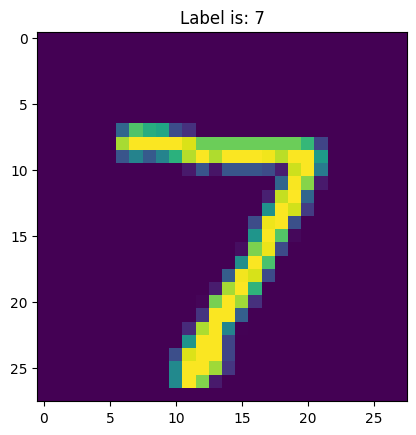

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(trainset, batch_size=batch_size)
test_dataloader = DataLoader(testset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    
    # plt.imshow(X[0].reshape(28,28))
    plt.imshow(X[0][0])
    
    plt.title(f"Label is: {y[0]}")
    plt.show()
    
    break

## Model

In [13]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [6]:
class MNISTRecognizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.nn_forward_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.nn_forward_stack(x)
        return logits

model = MNISTRecognizer().to(device)
print(model)

MNISTRecognizer(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nn_forward_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing and Training

In [7]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader, desc='Training loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device) # Xs, ys
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)


Training loop:   0%|          | 0/938 [00:00<?, ?it/s]

Training loop:   0%|          | 0/938 [00:00<?, ?it/s]

Training loop:   0%|          | 0/938 [00:00<?, ?it/s]

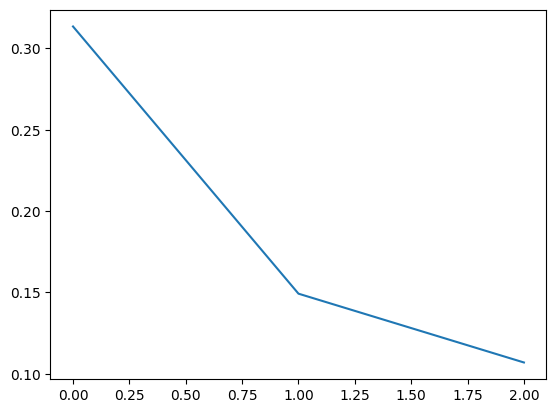

In [8]:
plt.plot(train_losses)

In [9]:
# make these work with your param
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
# https://www.kaggle.com/code/robikscube/train-your-first-pytorch-model-card-classifier

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# epochs = 5
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_dataloader, model, loss_fn, optimizer)
#     test(test_dataloader, model, loss_fn)
# print("Done!")


## Test your digit

In [10]:
m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
input_tensor = torch.Tensor(m).reshape(1,1, len(m), len(m[0]))
resized_tensor = nn.functional.interpolate(input_tensor, size=(28, 28))
# plt.imshow(resized_tensor[0][0])
# plt.show()
